In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [260]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 199)
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [261]:
# nyt_cum = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\NYT COVID Data.csv", parse_dates=['date'])
# # nyt_non_cum = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\NYT non-cumulative COVID data.csv", parse_dates=['date'])

# county_pop = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\594\Data\County pop data.csv")

# suburban_rural = pd.read_excel(r"C:/Users/mikha/OneDrive/Desktop/Dropbox/MIKHAEL NEW/mikhael school/Grad School/Master's/594/Data/Suburban vs Rural County Classifications.xlsx")

# Add "FIPS" column to county population dataset (thanks, census)

In [262]:
# def add_leading_zero(number_str):
    
#     if len(number_str) == 1:
#         return "0" + number_str
    
#     else:
#         return number_str
    
    
# def add_two_leading_zeros(number_str):
    
#     if len(number_str) == 2:
#         return "0" + number_str
    
#     elif  len(number_str) == 1:
#         return "00" + number_str
    
#     else:
#         return number_str

# county_pop['STATE'] = county_pop['STATE'].astype(str).apply(add_leading_zero)
# county_pop['COUNTY'] = county_pop['COUNTY'].astype(str).apply(add_two_leading_zeros)

# county_pop['FIPS'] = (county_pop['STATE'] + county_pop['COUNTY']).astype(int)

# Merge county population and suburban/rural classification datasets

In [263]:
# suburban_rural.rename(columns={'FIPS code':'FIPS', '2013 code':'Urban/Rural'}, inplace=True)

In [264]:
# county_info = county_pop.merge(suburban_rural, 
#                                how='outer',
#                                on='FIPS')

In [265]:
# for col in ['SUMLEV','REGION','DIVISION','STATE','COUNTY','STNAME']:
#     del county_info[col]

In [266]:
# county_info['FIPS'] = county_info['FIPS'].astype(float)

In [267]:
# county_info.to_csv(r"County Info.csv", index=False)

In [268]:
county_info = pd.read_csv(r"County Info.csv")

# Merge NYT datasets

## Get FIPS in non-cumulative nyt dataset

In [269]:
# def split_geoid_into_FIPS(geoid):
#     return geoid.split('-')[1]

## Process and rename

In [270]:
# nyt_cum.rename(columns={'fips':'FIPS', 'cases':'Cum. Cases', 'deaths':'Cum. Deaths'}, inplace=True)

## Convert cumulative cases to non-cumulative

In [271]:
# non_cum_cases_dict = {}

# for state in nyt_cum['state']:
#     print(state)
#     non_cum_cases_dict[state] = {}
    
#     for FIPS in nyt_cum[nyt_cum['state']==state]['FIPS'].unique():
#         print(FIPS)
#         non_cum_cases_dict[state][FIPS] = {}
        
#         for date in nyt_cum[(nyt_cum['state']==state) & (nyt_cum['FIPS']==FIPS)]['date'].unique():
#             print(date)
#             non_cum_cases_dict[state][FIPS][date] = {'Cum. Cases': nyt_cum[(nyt_cum['state']==state) & (nyt_cum['FIPS']==FIPS) & (nyt_cum['date']==date)]['Cum. Cases'],
#                                                     'Cum. Deaths': nyt_cum[(nyt_cum['state']==state) & (nyt_cum['FIPS']==FIPS) & (nyt_cum['date']==date)]['Cum. Deaths']}

In [272]:
# nyt_cum['Date before'] = nyt_cum['date'] - pd.Timedelta(days=1)

In [273]:
# nyt_cum['date'] = [date.strftime('%Y-%m-%d') for date in nyt_cum['date']]
# nyt_cum['Date before'] = [date.strftime('%Y-%m-%d') for date in nyt_cum['Date before']]

In [274]:
# daily_cases_dict = nyt_cum.groupby('FIPS')[['date','Cum. Cases', 'Cum. Deaths']].apply(lambda x: x.set_index('date').to_dict(orient='index')).to_dict()

In [275]:
# daily_cases = []
# daily_deaths = []
    
# for i, row in nyt_cum.iterrows():
#     print(i)
#     try:
#         daily_cases.append(daily_cases_dict[ row['FIPS'] ][ row['date'] ]['Cum. Cases'] - daily_cases_dict[ row['FIPS'] ][ row['Date before'] ]['Cum. Cases'])
#         daily_deaths.append(daily_cases_dict[ row['FIPS'] ][ row['date'] ]['Cum. Deaths'] - daily_cases_dict[ row['FIPS'] ][ row['Date before'] ]['Cum. Deaths'])
#     except Exception as e:
#         print(e, '\n    ',row['date'], row['state'], row['FIPS'])
#         daily_cases.append(np.nan)
#         daily_deaths.append(np.nan)

In [276]:
# nyt_cum['Daily Cases'] = daily_cases
# nyt_cum['Daily Deaths'] = daily_deaths

In [277]:
# del daily_cases, daily_deaths

In [278]:
# nyt_cum.to_csv(r"Processed NYT COVID Data.csv", index=False)

In [279]:
nyt_cum = pd.read_csv(r"Processed NYT COVID Data.csv")

In [280]:
# nyt_cum = nyt_cum[nyt_cum['county']!='Unknown']

## Merge both nyt datasets

In [281]:
# nyt = nyt_cum.merge(nyt_non_cum,
#                    how='outer',
#                    on=['FIPS','date'],
#                    suffixes=('_cum','_non_cum'))

### Replace "Unknown" entries with np.nan

In [282]:
# def repl_str(string):
#     if string=='Unknown':
#         return np.nan
#     else:
#         return string

# nyt['county_cum'] = nyt['county_cum'].apply(repl_str)
# nyt['county_non_cum'] = nyt['county_non_cum'].apply(repl_str)

# nyt['state_cum'] = nyt['state_cum'].apply(repl_str)
# nyt['state_non_cum'] = nyt['state_non_cum'].apply(repl_str)

### Delete redundant columns

In [283]:
# for col in ['geoid', 'cases_avg', 'cases_avg_per_100k', 'deaths_avg', 'deaths_avg_per_100k']:
#     del nyt[col]

## Collapse NYT data by week and FIPS

### convert date back to datetime

In [284]:
nyt_cum['date'] = pd.to_datetime(nyt_cum['date'])

In [285]:
# collapsed_nyt_weeks = nyt.set_index('date').groupby([pd.Grouper(freq='1W'), 'FIPS']).agg(
#     {'cases':'sum',
#      'deaths':'sum',
#     'FIPS':'median'}).droplevel('FIPS').reset_index()

collapsed_nyt_weeks = nyt_cum.set_index('date').groupby([pd.Grouper(freq='1W'), 'FIPS']).agg(
    {'Daily Cases':'sum',
     'Daily Deaths':'sum',
     'Cum. Cases':'mean',
     'Cum. Deaths': 'mean',
    'FIPS':'median'}).droplevel('FIPS').reset_index()

collapsed_nyt_months = nyt_cum.set_index('date').groupby([pd.Grouper(freq='1M'), 'FIPS']).agg(
    {'Daily Cases':'sum',
     'Daily Deaths':'sum',
     'Cum. Cases':'mean',
     'Cum. Deaths': 'mean',
    'FIPS':'median'}).droplevel('FIPS').reset_index()

In [286]:
del nyt_cum

In [287]:
collapsed_nyt_weeks['FIPS'] = collapsed_nyt_weeks['FIPS'].astype(int).astype(str)
collapsed_nyt_months['FIPS'] = collapsed_nyt_months['FIPS'].astype(int).astype(str)

In [288]:
def add_leading_zero_nyt(number_str):
    
    if len(number_str) == 4:
        return "0" + number_str
    
    else:
        return number_str

In [289]:
collapsed_nyt_weeks['FIPS'] = collapsed_nyt_weeks['FIPS'].apply(add_leading_zero_nyt).astype(float)
collapsed_nyt_months['FIPS'] = collapsed_nyt_months['FIPS'].apply(add_leading_zero_nyt).astype(float)

## Merge NYT data with county info

In [290]:
weeks_df = collapsed_nyt_weeks.merge(county_info,
                           on='FIPS',
                           how='left')

months_df = collapsed_nyt_months.merge(county_info,
                           on='FIPS',
                           how='left')

In [291]:
# del collapsed_nyt_weeks

### Get rid of error-inducing counties (puerto rico, deprecated, etc.)

In [292]:
erroneous_weeks_counties = weeks_df[weeks_df['County name'].isnull()]['FIPS'].unique()
weeks_df = weeks_df[ ~weeks_df['FIPS'].isin(erroneous_weeks_counties) ]

erroneous_months_counties = months_df[months_df['County name'].isnull()]['FIPS'].unique()
months_df = months_df[ ~months_df['FIPS'].isin(erroneous_months_counties) ]

### Set all negative cases and deaths to 0

## Add log and arcsinh-transformed case and death stats

In [293]:
def transform_col(col_name, dataframe):
    
    dataframe[f'Clipped {col_name}'] = dataframe[col].clip(lower=0)
    
    dataframe[f'Clipped {col_name} per 100k'] = (dataframe[f'Clipped {col_name}'] / dataframe['POPESTIMATE2019']) * 100000
    
    dataframe[f'Clipped log {col_name}'] = np.log(dataframe[f'Clipped {col_name}'] + 1)
    dataframe[f'Clipped arcsinh {col_name}'] = np.arcsinh(dataframe[f'Clipped {col_name}'] + 1)
    
    dataframe[f'Clipped log {col_name} per 100k'] = np.log(dataframe[f'Clipped {col_name} per 100k'] + 1)
    dataframe[f'Clipped arcsinh {col_name} per 100k'] = np.arcsinh(dataframe[f'Clipped {col_name} per 100k'] + 1)
    

In [294]:
for col in ['Daily Cases', 'Daily Deaths']:
    
    transform_col(col, weeks_df)
    
    transform_col(col, months_df)

## Detect and Remove Outliers

<AxesSubplot:>

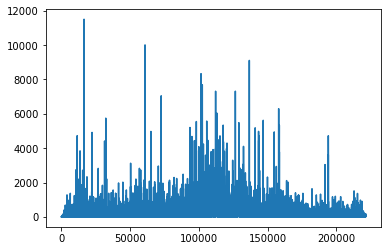

In [295]:
weeks_df['Clipped Daily Cases per 100k'].plot()

In [302]:
def label_outliers(df):
    
    erratic_fips = []
    try:
        df.set_index('FIPS', inplace=True)
    except:
        pass
    
    df['Outlier Score'] = 0
    
    df['Sharp Spike'] = 0
    
    for fips in df.index.unique():
        
        stddev = weeks_df.loc[fips]['Clipped Daily Cases'].std()
        
        normalized_changes = np.absolute(weeks_df.loc[fips]['Clipped Daily Cases'].diff() / stddev)

        df.loc[fips, 'Outlier Score'] = normalized_changes
        
        
        for x in normalized_changes:
            if x > 4:
                erratic_fips.append(fips)
        
    
    df.loc[erratic_fips, 'Sharp Spike'] = 1
        

In [305]:
weeks_df

,date,Daily Cases,Daily Deaths,Cum. Cases,Cum. Deaths,POPESTIMATE2019,State Abr.,County name,Urban/Rural,Clipped Daily Cases,Clipped Daily Cases per 100k,Clipped log Daily Cases,Clipped arcsinh Daily Cases,Clipped log Daily Cases per 100k,Clipped arcsinh Daily Cases per 100k,Clipped Daily Deaths,Clipped Daily Deaths per 100k,Clipped log Daily Deaths,Clipped arcsinh Daily Deaths,Clipped log Daily Deaths per 100k,Clipped arcsinh Daily Deaths per 100k,Outlier Score,Sharp Spike
FIPS,,,,,,,,,,,,,,,,,,,,,,,
4013.00,2020-01-26,0.00,0.00,1.00,0.00,4485414.00,AZ,Maricopa County,1.00,0.00,0.00,0.00,0.88,0.00,0.88,0.00,0.00,0.00,0.88,0.00,0.88,nan,0
6037.00,2020-01-26,0.00,0.00,1.00,0.00,10039107.00,CA,Los Angeles County,1.00,0.00,0.00,0.00,0.88,0.00,0.88,0.00,0.00,0.00,0.88,0.00,0.88,nan,0
6059.00,2020-01-26,0.00,0.00,1.00,0.00,3175692.00,CA,Orange County,1.00,0.00,0.00,0.00,0.88,0.00,0.88,0.00,0.00,0.00,0.88,0.00,0.88,nan,0
17031.00,2020-01-26,0.00,0.00,1.00,0.00,5150233.00,IL,Cook County,1.00,0.00,0.00,0.00,0.88,0.00,0.88,0.00,0.00,0.00,0.88,0.00,0.88,nan,0
53061.00,2020-01-26,0.00,0.00,1.00,0.00,822083.00,WA,Snohomish County,2.00,0.00,0.00,0.00,0.88,0.00,0.88,0.00,0.00,0.00,0.88,0.00,0.88,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037.00,2021-07-25,24.00,2.00,4898.50,42.00,42343.00,WY,Sweetwater County,5.00,24.00,56.68,3.22,3.91,4.05,4.75,2.00,4.72,1.10,1.82,1.74,2.45,0.28,0
56039.00,2021-07-25,13.00,0.00,3845.00,11.00,23464.00,WY,Teton County,5.00,13.00,55.40,2.64,3.33,4.03,4.73,0.00,0.00,0.00,0.88,0.00,0.88,0.09,0
56041.00,2021-07-25,16.00,0.00,2345.00,13.00,20226.00,WY,Uinta County,5.00,16.00,79.11,2.83,3.53,4.38,5.08,0.00,0.00,0.00,0.88,0.00,0.88,0.23,0


In [306]:
months_df.reset_index(inplace=True)

In [ ]:
label_outliers(weeks_df)

In [ ]:
label_outliers(months_df)

In [313]:
# months_df.set_index("FIPS", inplace=True)

erratic_fips = []
semi_erratic_fips = []

months_df['Outlier Score'] = 0

for fips in months_df.index.unique():
    stddev = months_df.loc[fips]['Clipped Daily Cases'].std()
    
    
    normalized_changes = np.absolute(months_df.loc[fips]['Clipped Daily Cases'].diff() / stddev)
    
    months_df.loc[fips, 'Outlier Score'] = normalized_changes
    
    
    for x in normalized_changes:
        if x > 5:
            erratic_fips.append((fips, x))
        if 4 <= x <= 5:
            semi_erratic_fips.append((fips,x))
            
FIPS_to_keep = np.array(list(set(months_df.index) - set([fips[0] for fips in erratic_fips])))
        

months_df = months_df.loc[FIPS_to_keep]
            
months_df.reset_index(inplace=True)

In [ ]:
for fips in erratic_fips:
    print(fips)
    weeks_df[weeks_df['FIPS']==fips[0]]['Clipped Daily Cases'].plot()
    plt.show()
    
    weeks_df[weeks_df['FIPS']==fips[0]]['Clipped Daily Cases'].rolling(4).mean().plot()
    plt.show()

In [ ]:
for fips in semi_erratic_fips:
    print(fips)
    weeks_df[weeks_df['FIPS']==fips[0]]['Clipped Daily Cases'].plot()
    
    plt.show()

In [ ]:
for fips in weeks_df['FIPS'].unique():
    if fips not in [fips[0] for fips in erratic_fips]:
        weeks_df[weeks_df['FIPS']==fips]['Clipped Daily Cases'].plot()
        plt.show()

In [ ]:
weeks_df.to_csv(r"C:/Users/mikha/OneDrive/Desktop/Dropbox/MIKHAEL NEW/mikhael school/Grad School/Master's/594/Data/FINAL DF BEFORE CT MERGE.csv", index=False)